# A quick quilt tutorial

`quilt` can simulate the dynamics of spiking networks alone, neural mass networks alone and join them in a multiscale network.

The `brain_data` and `spiking_data` folders contain the experimental data used in this demo (neuron's electrophysiological properties, connectivity, EEG lead field matrix, etc.)

## Generic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use("style.mplstyle")

# First: how to build & run each network

the `quilt.builder` module has all the high-level objects required to build the low-level ones

## Building the Spiking Network

In [2]:
from quilt.builder import ParametricSpikingNetwork

# Sets the objects starting from configuration files 
spikenet = ParametricSpikingNetwork.from_yaml(f"spiking_data/spiking_config/network.yaml", 
                                        f"spiking_data/spiking_config/neurons.yaml",
                                        [f"spiking_data/spiking_config/parametric.yaml"], 
                                        )
spikenet.monitor_spikes()
spikenet.set_parameters(dd=0) # Dopamine depletion set to zero

In [3]:
spikenet.build()
spikenet.run(dt=0.1, time=50) # Runs for 50 ms

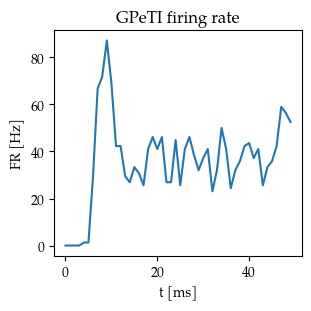

In [4]:
# Extracts the firing rates
firing_rates = spikenet.get_firing_rates(delta_ms=1, sliding=False)

plt.plot(firing_rates['GPeTI'])
plt.xlabel("t [ms]")
plt.ylabel("FR [Hz]");
plt.title("GPeTI firing rate");

> ⚠️ **Warning**
>  
> the state of each neuron (membrane potential, etc.) can be obtained by `spikenet.get_neuron_states()`, but monitoring states slows down the simulation

## Building the neural mass network

In [2]:
# Parameters of the oscillators: these were already optimized with an EEG match
osc_pars = dict(
    C=169.1,
    He=4.91,
    Hi=12.9,
    U_exc=0.22,
    U_inh=0.045,
    sigma_exc=1.69,
    sigma_inh=0.119,
    ke=0.0956,
    ki=0.058,
    rmax=0.00678,
    s=0.956,
    v0=7.66,
    epsC_inh_pre=0.323,
    epsC_inh_post=0.331,
    epsC_exc_pre=-0.387,
    epsC_exc_post=-0.279,
)

In [3]:
from quilt.builder import OscillatorNetwork
osc_pars['oscillator_type']='binoisy-jansen-rit'
nmnet = OscillatorNetwork.homogeneous_from_TVB('brain_data/connectivity/connectivity_desikan.zip', 
                                            osc_pars,
                                            global_weight=675, 
                                            conduction_speed=0.8)

In [4]:
nmnet.build()
nmnet.initialize(tau=120, vmin=0, vmax=25) # NM networks need to bee initialized to have a fake past
nmnet.run(5000)

shape is (5319, 6)


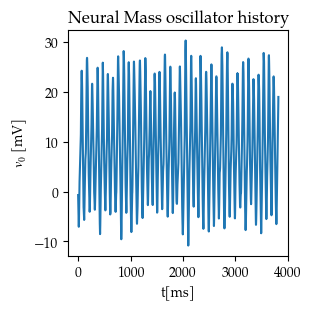

In [5]:
# Plot thes state of oscillators: first axis is time, other are oscillator dependent
# For the binoisy Jansen Rit is (v_0, v_1, v_2, and relative derivatives)
region = 'r_frontalpole'
print(f"shape is {nmnet.oscillators[region].history.shape}")
plt.plot(nmnet.oscillators[region].history[1500:,1]- nmnet.oscillators[region].history[1500:,2]);
plt.xlabel('t[ms]');
plt.title("Neural Mass oscillator history");
plt.ylabel("$v_0$ [mV]");

Data is hard to interpret by raw NM signals. Some utility functions help.

In [6]:
nmnet.tau_init

316.12845

## Visualizing Neural Mass data

### EEGcap

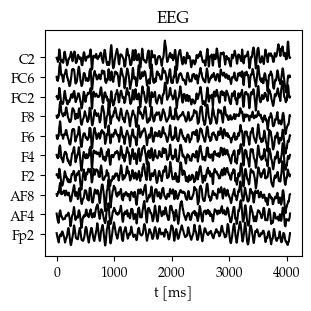

In [7]:
## The EEGcap is composed of the electrode gain matrix (neural mass, channel) and the spatial position of electrodes
from quilt.eeg import EEGcap

eegcap = EEGcap("brain_data/leadfield/nlfm_control.pkl", 
                "brain_data/sensors/oostenveld_map.pkl")

# Filter arguments
eeg_filt = dict(sfreq=1e3, l_freq=1, h_freq=90, verbose=False)

# Production of the EEG signals
signals = eegcap.eeg(nmnet, eeg_filt, 
                     init_to_skip=4 # Skips N times the initialization time of the network
                     )

#  Plots the EEG
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(signals[i] + 4*i, color='k')
ax.set_yticks(4*np.arange(10), 
              labels=eegcap.electrodes[:10]
              );
ax.set_title("EEG")
ax.set_xlabel("t [ms]");

Computing the normalized psds

Text(0, 0.5, 'PSD of channel Fp2')

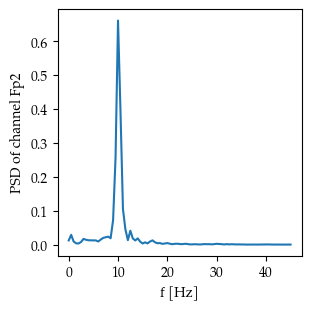

In [8]:
f, psds = eegcap.compute_normalized_psd(fs=1e3)
plt.plot(f, psds[0])
plt.xlabel('f [Hz]')
plt.ylabel(f"PSD of channel {eegcap.electrodes[0]}")

plotting a topomap example: the value of the psds at 10 Hz

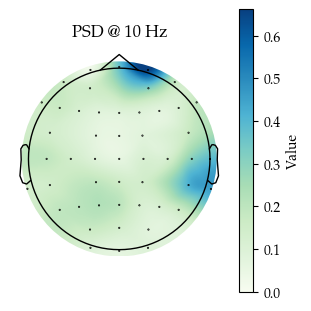

In [9]:
from mne.viz import plot_topomap

# Params for mne's plot_topomap
plot_kwargs = dict(sphere=0.5, show=False, cmap=plt.cm.GnBu, image_interp="cubic", contours=0)

fig, ax = plt.subplots()
im, _ = plot_topomap(
                psds[:, np.where(f==10)[0][0]],
                eegcap.get_electrode_projection("equidist"), 
                axes=ax, 
                **plot_kwargs
                )
ax.set_title("PSD @ 10 Hz")
plt.colorbar(im, ax=ax, label=r'Value');


### Visualizing data directly on the cortical surface: ParcelledCortexPlot

In [10]:
from quilt.view import ParcelledCortexPlot

plotter = ParcelledCortexPlot(f"brain_data/surfaces/cortex_16384.zip", 
                            f"brain_data/connectivity/connectivity_desikan.zip",
                            f"brain_data/mappings/regionmapping_geodesic_closest.txt",
                            width_inches=2.5, height_inches=2)


fake_random_data = {oscillator:np.random.randint(5) for oscillator in nmnet.oscillators}
plotter.set_scalar(fake_random_data, "fake data")
plotter.plot('fake data',scalar_bar_fontsize=30, scalar_bar_title="Fake data")
plotter.show()

Widget(value='<iframe src="http://localhost:38423/index.html?ui=P_0x7955cea2d5e0_0&reconnect=auto" class="pyvi…

In [11]:
plotter.screenshot("example_screenshot.png")

### Extra: Animating data on the cortical surface

on linux the `imageio-ffmpeg` library is required to save in `.mp4` format. Use the `.gif` format otherwise.

In [23]:
import pyvista as pv
pv.global_theme.transparent_background = True

# Assign random data to the mesh: this frame is skipped
fake_random_data = {oscillator:np.random.randint(50) for oscillator in nmnet.oscillators}
plotter.set_scalar(fake_random_data, "membrane potential")
plotter.plot('membrane potential', 
             off_screen=True,   # Turns off the render window
             clim=[0, 50],      # Color map limits
             cmap=plt.cm.GnBu,  # Color map
            #  scalar_bar_title="Pyr. potential [mV]", 
            #  scalar_bar_fontsize=35
            scalar_bar=False
             )
plotter.plotter.zoom_camera(1.5)
# plotter.screenshot("test_transparency.png")
# plotter.show()


plotter.plotter.open_movie("test_transparency.gif", framerate=24, quality=5)

for frame in range(400):

    # Outputs the current frame
    if frame % 10 == 0:
        print(frame, end="-", flush=True)

    # Compute the region values: whatever you want
    # Values must be dictionary of the form {region_name:value}
    values = {nm: nmnet.oscillators[nm].history[1500 + 4*frame, 1] - nmnet.oscillators[nm].history[1500 + 4*frame, 2] for nm in nmnet.oscillators}
    
    # Sets the scalar to the mesh
    plotter.set_scalar(values, 'membrane potential')
    plotter.plotter.camera.azimuth += 0.5       # Moves the camera azimuth (rotate xy)
    # plotter.plotter.camera.elevation += 0.1   # Moves the camera polar angle

    # Writes the frame
    plotter.plotter.write_frame()

# IMPORTANT: Closes the plotter. The file will not be saved otherwise
plotter.plotter.close()

0-10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-

## Multiscale

> WARNING
> 
> Naming inconsistency: *supersynapses* sometimes also appear as *transducers*.
>
> (I will rename things sooner or later)

In [18]:
from quilt.builder import MultiscaleNetwork

multinet = MultiscaleNetwork(spikenet, nmnet, "spiking_data/supsyn_config/supersynapses.yaml")

multinet.set_multiscale_projections(file="spiking_data/supsyn_config/supsyns_connectivity.yaml", 
                                    T2O_coupling=2.0, # equivalent of baso-cortical coupling
                                    O2T_coupling=5.0  # equivalent of cortico-basal coupling
                                    )
multinet.build()

# Sets the timesteps of the integration
multinet.set_evolution_contextes(dt_short=0.1, dt_long=1.0)

# Initialize the history
multinet.initialize(tau=120.0, vmin=0, vmax=25)

[2026-01-22 12:07:25] WARNING: MultiscaleNetwork: 2 transducers were found to have no inputs
[2026-01-22 12:07:25] WARNING: MultiscaleNetwork: 3 transducers were found to have no outputs


In [19]:
multinet.run(time=1000)

### Extracting data from multinet

Works as before: the multinet has both the spiking network and the neural mass network as attributes:

In [21]:
nmnet_multi = multinet.oscillator_network
spikenet_multi = multinet.spiking_network

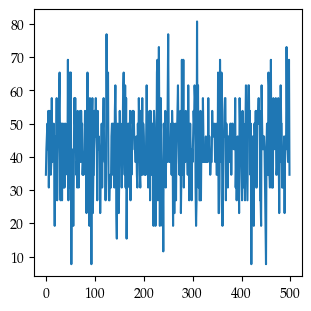

In [22]:
firing_rates = spikenet_multi.get_firing_rates(delta_ms=1, sliding=False)
plt.plot(firing_rates['GPeTA'][500:])